In [ ]:
import jax
import jax.numpy as jnp

In [ ]:
target_dim = 1
width = 16
depth = 2

@jax.jit
def convergence_measure(v, max_val = 1e6):
  """
  turn the training trajectory into a single number which looks pretty in an
  image
  """

  fin = jnp.isfinite(v)
  v = v*fin + max_val*(1-fin)

  v /= v[0]
  exceeds = (v > max_val)
  v = v*(1-exceeds) + max_val*exceeds

  converged = (jnp.mean(v[-20:]) < 1) # average over any oscillatory behavior
  return jnp.where(converged, -jnp.sum(v), jnp.sum(1/v))

# jit and vectorise the convergence measure
convergence_measure_vmap = jax.jit(jax.vmap(convergence_measure, in_axes=(0,), out_axes=0))

def net(theta, X):
  for W in theta:
    Z = jnp.dot(X, W)/jnp.sqrt(W.shape[0])
    X = jax.nn.tanh(Z*jnp.sqrt(2))
  return Z /jnp.sqrt(W.shape[0])

def init(rng, width, depth):
  rng = jax.random.split(rng, depth)
  theta = []
  out_width = width
  for i in range(depth):
    if i ==depth-1:
      out_width = target_dim
    W = jax.random.normal(rng[i], (width, out_width))
    theta.append(W)
  return theta

def loss(theta, X, Y):
  Z = net(theta, X)
  return jnp.mean((Z-Y)**2) # MSE Loss function

def hparams_f(hparams, theta):
  """
  convert hyperparameters into a learning rate for each layer in the network
  """
  lr = []
  for i, t in enumerate(theta):
    lr.append(hparams[i%len(hparams)])
  return lr

def train_step(rng, theta, hparams, X, Y):
  learning_rates = hparams_f(hparams, theta)
  _loss, _grad  = jax.value_and_grad(loss)(theta, X, Y)
  return jax.tree_map(lambda t, g, lr: t-lr*g, theta, _grad, learning_rates), _loss

train_step_lrvmap = jax.jit(
    jax.vmap(train_step, in_axes=(None, 0, 0, None, None), out_axes=(0,0)),
    donate_argnums=(0,1))


def train(theta, hparams, X, Y, num_steps, outer_batch_size=50000):
  bs = hparams.shape[0]

  if bs > outer_batch_size:
    # split up the hyperparameter search grid if we would run out of memory
    return jnp.concatenate(
        (train(theta, hparams[:bs//2], X, Y, num_steps),
        train(theta, hparams[bs//2:], X, Y, num_steps)),
        axis=0)

  rng = jax.random.PRNGKey(1337)
  rng = jax.random.split(rng, num_steps)

  losses = []
  _theta = jax.tree_map(lambda u: jnp.tile(u, (bs,) + (1,)*len(u.shape)), theta)
  for _rng in rng:
    _theta, _loss = train_step_lrvmap(_rng, _theta, hparams, X, Y)
    losses.append(_loss)

  return convergence_measure_vmap(jnp.stack(losses, axis=-1))

In [ ]:
def gen_img(mnmx, dataset_param_multiple=0.5, opt_steps=500, resolution=512):
  """
  generate an image of the hyperparameter landscape,
  for a range of hyperparameter values specified by mnmx
  """

  mn1, mx1, mn2, mx2 = mnmx
  rng = jax.random.PRNGKey(0)
  rng, srng = jax.random.split(rng)
  theta = init(srng, width, depth)

  n_params = jnp.sum(jnp.array(jax.tree_map(lambda u: u.size, theta)))

  rng, srng = jax.random.split(rng)


  batch_size = int(n_params*dataset_param_multiple/target_dim)

  X = jax.random.normal(srng, (batch_size, width))
  rng, srng = jax.random.split(rng)
  Y = jax.random.normal(srng, (batch_size, target_dim))

  gg1 = jnp.logspace(mn1, mx1, resolution)
  gg2 = jnp.logspace(mn2, mx2, resolution)

  # return
  lr0, lr1 = jnp.meshgrid(gg2, gg1)
  lr = jnp.stack([lr0.ravel(), lr1.ravel()], axis=-1)

  V = train(theta, lr, X, Y, opt_steps)

  return V.reshape((resolution, resolution))

def cdf_img(x, x_ref, buffer=0.25):
  """
  rescale x, relative to x_ref (x_ref is often the same as x), to achieve a uniform
  distribution over values with positive and negative intensities, but also to
  preserve the sign of x. This makes for a visualization that shows more
  structure.
  """

  u = jnp.sort(x_ref.ravel())


  num_neg = jnp.sum(u<0)
  num_nonneg = u.shape[0] - num_neg
  v = jnp.concatenate((jnp.linspace(-1,-buffer,num_neg), jnp.linspace(buffer,1,num_nonneg)), axis=0)


  y = jnp.interp(x, u, v)
  return -y

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
def plot_imshow(img, x_range, y_range, filename=None):
  plt.imshow(img_3, extent=(mnx, mxx, mny, mxy), aspect='auto', cmap='plasma')
  plt.grid(False)


  def format_tick_label(value):
      return r"$10^{{{:.3g}}}$".format(value)

  x_ticks = [mnx, mxx]
  y_ticks = [mny, mxy]

  plt.xticks(x_ticks, [format_tick_label(x) for x in x_ticks])
  plt.yticks(y_ticks, [format_tick_label(y) for y in y_ticks])
  plt.xlabel("Input learning rate")
  plt.ylabel("Output learning rate")

  plt.tick_params(axis='both',
                  which='major',
                  direction='in',
                  length=10,
                  width=3,
                  colors='black',
                  pad=5,
                  labelsize=10,
                  labelcolor='black',
                  bottom=True, top=True, left=True, right=True,
                  labelbottom=True, labeltop=False,
                  labelleft=True, labelright=False)


  font = {
      'weight': 'normal',
      'size': 14,
  }


  plt.xlabel('Input layer learning rate', fontdict=font)
  plt.ylabel('Output layer learning rate', fontdict=font)

  # Ensure the plot is enclosed in a square border
  plt.gca().set_frame_on(True)

  if filename:
    plt.savefig(f"/content/drive/My Drive/ChaosImages/{filename}.png", transparent=True, dpi=800)

  plt.show()
  plt.draw()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import seaborn as sns
sns.set_theme()

In [ ]:
mny, mxy = 2.2, 2.6
mnx, mxx = -5, -4

mnmx = mny, mxy, mnx, mxx
img = gen_img(mnmx, resolution = 2048)


img_2 = cdf_img(img, img, )
img_3 = np.flipud(img_2)

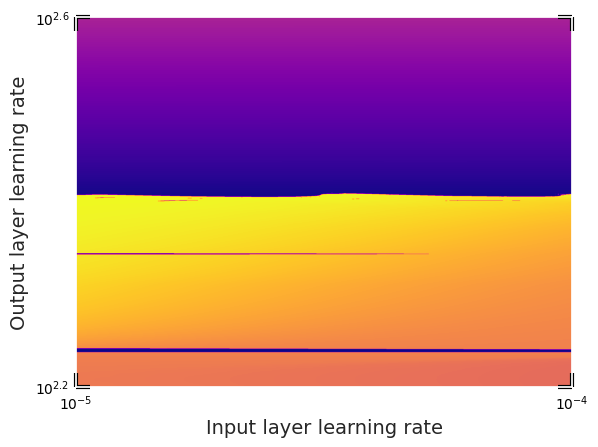

<Figure size 640x480 with 0 Axes>

In [ ]:
plot_imshow(img_3, (mnx, mxx), (mny, mxy))

In [ ]:
import PIL
import numpy as np
cmap = plt.get_cmap('plasma')  # You can choose any available colormap here
img_3_normalized = (img_3 - np.min(img_3)) / (np.max(img_3) - np.min(img_3))

colored_img = cmap(img_3_normalized)  # This applies the colormap to your image data
colored_img_8bit = (colored_img * 255).astype(np.uint8)

# Convert to Pillow image
image = PIL.Image.fromarray(colored_img_8bit)
# file_path = '/content/drive/My Drive/ChaosImages/chaos_image_zoom_top_left.png'
# plt.savefig(file_path)
# Save the image
file_path = "/content/drive/My Drive/ChaosImages/0.png"  # Specify your file path here
image.save(file_path)
